x_train shape: (50000, 32, 32, 3)
50000 train samples
y_train shape: (50000, 1)
50000 train samples
x_test shape: (10000, 32, 32, 3)
10000 test samples
y_test shape: (10000, 1)
10000 test samples


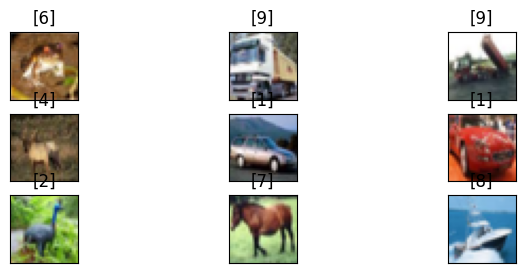

In [72]:
from tensorflow.keras.datasets import cifar10
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)
print(y_test.shape[0], 'test samples')

# display the first 9 images and their labels
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,3))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title(str(y_train[i]))
plt.show()

In [76]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Select birds as the normal class (class 2) and airplanes as anomalies (class 0)
normal_class = 2
anomaly_class = 0

# Filter the data to only include the normal class and anomaly class
x_train_normal = x_train[y_train.flatten() == normal_class]

x_test_normal = x_test[y_test.flatten() == normal_class]
x_test_anomaly = x_test[y_test.flatten() == anomaly_class]

# Normalize pixel values to [0, 1]
x_train_normal = x_train_normal.astype('float32') / 255

x_test_normal = x_test_normal.astype('float32') / 255
x_test_anomaly = x_test_anomaly.astype('float32') / 255

# Define the Autoencoder model
input_shape = (32, 32, 3)
encoding_dim = 128

input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Compile the Autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Define the fraction of anomaly data points to inject into normal data
oe_fraction = 0.1

# Inject anomaly data points into normal data
x_train_oe = np.concatenate((x_train_normal, x_test_anomaly[:int(oe_fraction * len(x_train_normal))]))

# Create a label array for the injected anomaly data points
y_train_oe_anomaly = np.ones((int(oe_fraction * len(x_train_normal)),))  # label as anomalies (1)

# Create a label array for the normal data points
y_train_normal_label = np.zeros((len(x_train_normal),))  # label as normal (0)

# Concatenate the label arrays
y_train_oe = np.concatenate((y_train_normal_label, y_train_oe_anomaly))

# Compile the Autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder model with Outlier Exposure (OE)
autoencoder.fit(x_train_oe, x_train_oe, epochs=10, batch_size=256, validation_data=(x_test_normal, x_test_normal))

# Train the Autoencoder model
#autoencoder.fit(x_train_normal, x_train_normal, epochs=10, batch_size=256, validation_data=(x_test_normal, x_test_normal))

# Evaluate the Autoencoder model on normal data
normal_reconstructions = autoencoder.predict(x_test_normal)
normal_reconstruction_loss = np.mean((normal_reconstructions - x_test_normal) ** 2)
print("Normal reconstruction loss:", normal_reconstruction_loss)

# Evaluate the Autoencoder model on anomaly data
anomaly_reconstructions = autoencoder.predict(x_test_anomaly)
anomaly_reconstruction_loss = np.mean((anomaly_reconstructions - x_test_anomaly) ** 2)

print("Anomaly reconstruction loss:", anomaly_reconstruction_loss)

[0. 0. 0. ... 1. 1. 1.]


In [75]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get all test data (normal and anomalous)
x_test_all = np.concatenate((x_test_normal, x_test_anomaly), axis=0)

# Reconstruct all test images
decoded_imgs = autoencoder.predict(x_test_all)

# Calculate reconstruction errors (MSE)
mse = np.mean(np.power(x_test_all - decoded_imgs, 2), axis=(1, 2, 3))

# Set threshold
threshold = 0.01

# Classify as anomaly if reconstruction error is above threshold
y_pred = (mse > threshold).astype(int)

# Get true labels (1 for airplanes (anomalies), 0 for birds)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.5695
Precision: 0.564531104921077
Recall: 0.608
F1-Score: 0.5854597977852672


## With OE
- Accuracy: 0.5455
- Precision: 0.5465711361310133
- Recall: 0.534
- F1-Score: 0.5402124430955993



## WITHOUT OE 

- Accuracy: 0.5645
- Precision: 0.5683987274655355
- Recall: 0.536
- F1-Score: 0.5517241379310345

In [85]:
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert class labels to binary (birds = 0, others = 1)
y_train_binary = np.where(y_train == 2, 0, 1)  # 2 is the class label for birds
y_test_binary = np.where(y_test == 2, 0, 1)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape input data
x_train = x_train.reshape(-1, 32 * 32 * 3)
x_test = x_test.reshape(-1, 32 * 32 * 3)

# Define autoencoder architecture
input_dim = x_train.shape[1]
encoding_dim = 128

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train autoencoder on birds (normal class)
autoencoder.fit(
    x_train[y_train_binary.flatten() == 0], 
    x_train[y_train_binary.flatten() == 0], 
    epochs=50, 
    batch_size=128, 
    shuffle=True
    )

# Evaluate autoencoder on test dataset
y_pred = autoencoder.predict(x_test)
y_pred_binary = np.where(y_pred > 0.5, 0, 1)  # threshold to determine anomalies
y_pred_binary = np.argmax(y_pred_binary, axis=1)

# Evaluate anomaly detection performance
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Anomaly detection accuracy:", accuracy)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 16/50
40/40 ━

# Deep One-Class Classification (DOCC) method 

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1685
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.7326e-10
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.9004e-13
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.7677e-13
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.9109e-13
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.6447e-13
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.6975e-13
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.8545e-13
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.3690e-13
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.6139e-13
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.3032e-13
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.0148e-13
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.3904e-13
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0131e-13
Epoch 15/50
20/20 ━━━━━━━━━━━━

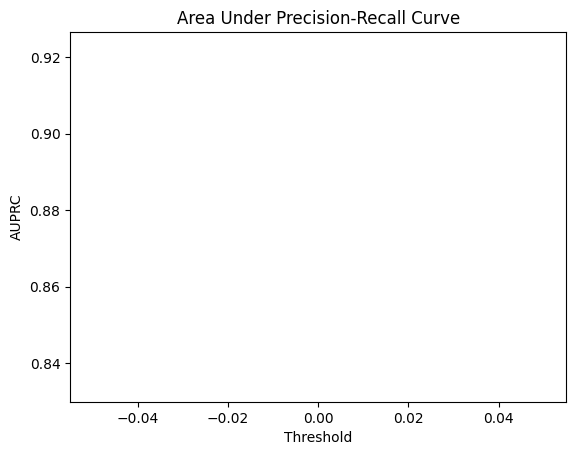

In [92]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert class labels to binary (birds = 0, others = 1)
y_train_binary = np.where(y_train == 2, 0, 1)  # 2 is the class label for birds
y_test_binary = np.where(y_test == 2, 0, 1)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Split training data into normal and anomalous classes
x_train_normal = x_train[y_train_binary.flatten() == 0]
x_train_anomalous = x_train[y_train_binary.flatten() == 1]

# Select 10% of anomalous class for Outlier Exposure
num_oe_samples = int(0.2 * len(x_train_anomalous))
x_train_oe = x_train_anomalous[:num_oe_samples]

# Combine normal class and OE samples for training
x_train_oe_combined = np.concatenate((x_train_normal, x_train_oe))
y_train_oe_combined = np.concatenate((np.zeros(len(x_train_normal)), np.ones(num_oe_samples)))

# Define DOCC model architecture
input_layer = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Define DOCC model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile DOCC model
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=True))

# Train DOCC model with Outlier Exposure
model.fit(x_train_normal, np.zeros(len(x_train_normal)), epochs=50, batch_size=256, shuffle=True)

# Evaluate DOCC model on test dataset
y_pred = model.predict(x_test)
y_pred_binary = np.where(y_pred > 0.5, 0, 1)  # threshold to determine anomalies

# Evaluate anomaly detection performance
accuracy = accuracy_score(y_test_binary, y_pred_binary)

Anomaly detection accuracy: 0.9
Precision: 0.9
Recall: 1.0
F1-Score: 0.9473684210526315
AUPRC: 0.8782140845881867


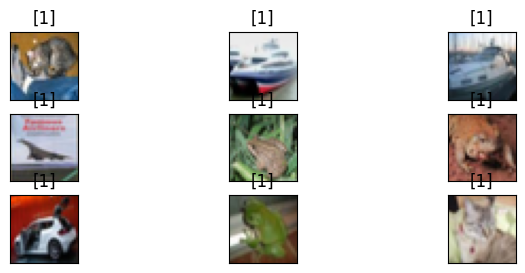

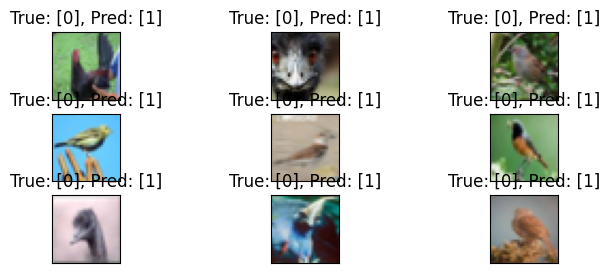

<Figure size 800x300 with 0 Axes>

In [101]:
print("Anomaly detection accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Calculate AUPRC
auprc = average_precision_score(y_test_binary, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUPRC:", auprc)

import matplotlib.pyplot as plt

# Display the first 9 images and their predicted labels (0: bird, 1: other)
fig = plt.figure(figsize=(8, 3))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i])
    ax.set_title(str(y_pred_binary[i]))
plt.show()

# display the images where prediction is anamoly but true label is normal
fig = plt.figure(figsize=(8, 3))
count = 0
for i in range(len(y_test_binary)):
    if y_pred_binary[i] == 1 and y_test_binary[i] == 0:
        ax = fig.add_subplot(3, 3, count + 1, xticks=[], yticks=[])
        ax.imshow(x_test[i])
        ax.set_title("True: " + str(y_test_binary[i]) + ", Pred: " + str(y_pred_binary[i]))
        count += 1
    if count == 9:
        break
plt.show()

# display the images where prediction is normal but true label is anamoly
fig = plt.figure(figsize=(8, 3))
count = 0
for i in range(len(y_test_binary)):
    if y_pred_binary[i] == 0 and y_test_binary[i] == 1:
        ax = fig.add_subplot(3, 3, count + 1, xticks=[], yticks=[])
        ax.imshow(x_test[i])
        ax.set_title("True: " + str(y_test_binary[i]) + ", Pred: " + str(y_pred_binary[i]))
        count += 1
    if count == 3:
        break
plt.show()
